In [1]:
# ------------------------------------------------------------------
# Import required libraries
# ------------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn for scaling and evaluation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Path and sys for src import
from pathlib import Path
import sys


In [3]:
# ------------------------------------------------------------------
# Setup paths to src
# ------------------------------------------------------------------

# Set path to the repo root and src folder
repo_root = Path("/Users/ruchitiwari/Desktop/Final CMOR 438/CMOR_438_Final_Repository")
src_path = repo_root / "src"
sys.path.append(str(src_path))

# Import DBSCAN community detection model
from rice_ml.unsupervised_learning.dbscan import DBSCANCommunityDetector


In [5]:
# ------------------------------------------------------------------
# Step 1: Load and inspect Obesity dataset
# ------------------------------------------------------------------

# Load dataset (same data folder as income dataset)
data_path = repo_root / "data" / "Obesity_Dataset.csv"
df = pd.read_csv(data_path)

# Quick inspection
print("Dataset shape:", df.shape)
display(df.head())
print("\nData types:")
display(df.dtypes)
print("\nMissing values per column:")
display(df.isnull().sum())
print("\nDistribution of target variable (NObeyesdad):")
display(df['NObeyesdad'].value_counts())



Dataset shape: (2111, 17)


,Age,Gender,Height,Weight,CALC,FAVC,FCVC,NCP,SCC,SMOKE,CH2O,family_history_with_overweight,FAF,TUE,CAEC,MTRANS,NObeyesdad
0,21.0,Female,1.62,64.0,no,no,2.0,3.0,no,no,2.0,yes,0.0,1.0,Sometimes,Public_Transportation,Normal_Weight
1,21.0,Female,1.52,56.0,Sometimes,no,3.0,3.0,yes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,23.0,Male,1.80,77.0,Frequently,no,2.0,3.0,no,no,2.0,yes,2.0,1.0,Sometimes,Public_Transportation,Normal_Weight
3,27.0,Male,1.80,87.0,Frequently,no,3.0,3.0,no,no,2.0,no,2.0,0.0,Sometimes,Walking,Overweight_Level_I
4,22.0,Male,1.78,89.8,Sometimes,no,2.0,1.0,no,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II



Data types:


Age                               float64
Gender                             object
Height                            float64
Weight                            float64
CALC                               object
FAVC                               object
FCVC                              float64
NCP                               float64
SCC                                object
SMOKE                              object
CH2O                              float64
family_history_with_overweight     object
FAF                               float64
TUE                               float64
CAEC                               object
MTRANS                             object
NObeyesdad                         object
dtype: object


Missing values per column:


Age                               0
Gender                            0
Height                            0
Weight                            0
CALC                              0
FAVC                              0
FCVC                              0
NCP                               0
SCC                               0
SMOKE                             0
CH2O                              0
family_history_with_overweight    0
FAF                               0
TUE                               0
CAEC                              0
MTRANS                            0
NObeyesdad                        0
dtype: int64


Distribution of target variable (NObeyesdad):


NObeyesdad
Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: count, dtype: int64

In [6]:
# ------------------------------------------------------------------
# Step 2: Preprocessing and feature scaling for DBSCAN
# ------------------------------------------------------------------

from sklearn.preprocessing import StandardScaler

# Encode categorical variables
df_encoded = pd.get_dummies(df.drop(columns=['NObeyesdad']), drop_first=True)

# Extract numeric features (optional: if you want to scale only numeric)
numeric_cols = df_encoded.select_dtypes(include=[np.number]).columns

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded[numeric_cols])

# Check shapes
print("Encoded feature matrix shape:", df_encoded.shape)
print("Scaled feature matrix shape:", X_scaled.shape)


Encoded feature matrix shape: (2111, 23)
Scaled feature matrix shape: (2111, 8)


In [7]:
# ------------------------------------------------------------------
# Step 3: DBSCAN clustering
# ------------------------------------------------------------------

from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd

# Initialize DBSCAN
dbscan = DBSCAN(
    eps=1.5,        # distance threshold; adjust based on data
    min_samples=10, # minimum points to form a cluster
    metric='euclidean'
)

# Fit and get cluster labels
db_labels = dbscan.fit_predict(X_scaled)

# Add cluster labels to original dataframe
df['dbscan_cluster'] = db_labels

# Basic cluster info
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
n_noise = list(db_labels).count(-1)
print(f"Number of clusters detected: {n_clusters}")
print(f"Number of noise points: {n_noise}")

# Cluster size distribution
cluster_sizes = pd.Series(db_labels).value_counts().sort_index()
print("\nCluster size distribution:")
print(cluster_sizes)


Number of clusters detected: 3
Number of noise points: 222

Cluster size distribution:
-1     222
 0    1864
 1       6
 2      19
Name: count, dtype: int64


In [8]:
# ------------------------------------------------------------------
# Step 4: Analyze DBSCAN cluster composition
# ------------------------------------------------------------------

# Separate noise points (-1) if you want, or include them in analysis
clusters_to_analyze = [c for c in set(db_labels) if c != -1]

# Numeric features
numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
numeric_summary = df[df['dbscan_cluster'].isin(clusters_to_analyze)].groupby('dbscan_cluster')[numeric_cols].mean()
print("Numeric feature averages per cluster:\n")
print(numeric_summary)

# Categorical features
categorical_cols = df.select_dtypes(include='object').columns.tolist()
categorical_summary = df[df['dbscan_cluster'].isin(clusters_to_analyze)].groupby('dbscan_cluster')[categorical_cols].agg(lambda x: x.value_counts().index[0])
print("\nMost common categorical feature values per cluster:\n")
print(categorical_summary)


Numeric feature averages per cluster:

                      Age    Height     Weight      FCVC       NCP      CH2O  \
dbscan_cluster                                                                 
0               23.673072  1.704493  88.244200  2.439289  2.738528  2.013076   
1               37.283355  1.677311  78.711085  2.100976  3.017527  1.181859   
2               39.156100  1.577698  80.183396  2.267824  1.375148  1.783917   

                     FAF       TUE  dbscan_cluster  
dbscan_cluster                                      
0               0.954136  0.646897             0.0  
1               0.108651  1.536302             1.0  
2               1.594993  0.000000             2.0  

Most common categorical feature values per cluster:

                Gender       CALC FAVC SCC SMOKE  \
dbscan_cluster                                     
0                 Male  Sometimes  yes  no    no   
1               Female         no  yes  no    no   
2               Female  Sometimes

/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: divide by zero encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: overflow encountered in matmul
  X_transformed = X @ self.components_.T
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/decomposition/_base.py:148: RuntimeWarning: invalid value encountered in matmul
  X_transformed = X @ self.components_.T


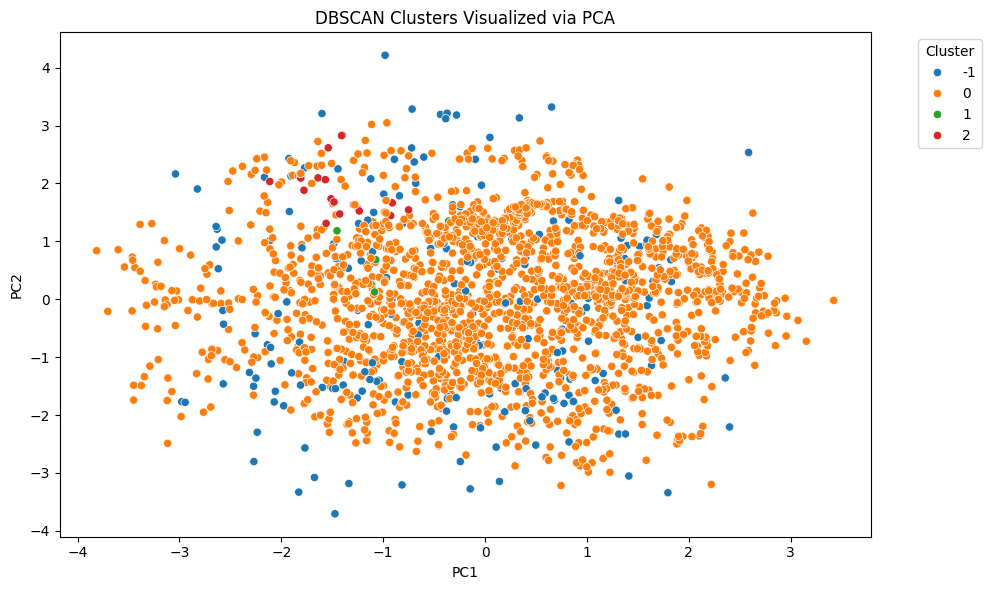

In [9]:
# ------------------------------------------------------------------
# Step 5: Visualize DBSCAN clusters via PCA
# ------------------------------------------------------------------

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Reduce features to 2 principal components
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=X_pca[:, 0],
    y=X_pca[:, 1],
    hue=df['dbscan_cluster'],   # cluster labels
    palette="tab10",
    legend="full"
)
plt.title("DBSCAN Clusters Visualized via PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [10]:
# ------------------------------------------------------------------
# Step 6: Numeric evaluation of DBSCAN clustering
# ------------------------------------------------------------------

from sklearn.metrics import silhouette_score

# Silhouette score cannot include noise points (-1), so filter them out
mask = df['dbscan_cluster'] != -1
X_filtered = X_scaled[mask]
labels_filtered = df.loc[mask, 'dbscan_cluster']

# Compute silhouette score
sil_score = silhouette_score(X_filtered, labels_filtered)
print(f"Silhouette Score of DBSCAN Clustering (excluding noise points): {sil_score:.4f}")


Silhouette Score of DBSCAN Clustering (excluding noise points): 0.0802


/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/ruchitiwari/Library/Python/3.9/lib/python/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b
